# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.mixture import GaussianMixture

In [2]:
rcupd = {
    'figure.figsize': (5, 4),
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': 'cm',
    'font.size': 12,
}
plt.rcParams.update(rcupd)

# Plotters

In [3]:
def do_scatters(X, y, cols, swel_unit, ylim):
    ''' X and y are numpy column arrays '''

    # number of columns is hardcoded here
    assert X.shape[1] == 7

    fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(10, 6))
    for i in range(7):
        axes[i//4, i%4].scatter(X[:,i], y, s=1)
        axes[i//4, i%4].set_xlabel(cols[i])
    
    fig.delaxes(axes[1,3])
    fig.supylabel('Fuel Swelling (' + swel_unit + ')')
    
    plt.ylim(*ylim)
    plt.tight_layout()
    plt.show()

    return None

In [4]:
def plot_two_clusters(cluster_0, cluster_1, cols, swel_unit, ylim):
    ''' clusters contain both X and y '''

    # number of columns is hardcoded here
    assert cluster_0.shape[1] == 8
    assert cluster_1.shape[1] == 8

    fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(10, 6))
    for i in range(7):
        axes[i//4, i%4].scatter(cluster_0[:,i], cluster_0[:,-1], s=1, label='0')
        axes[i//4, i%4].scatter(cluster_1[:,i], cluster_1[:,-1], s=1, label='1')
        axes[i//4, i%4].set_xlabel(cols[i])
    
    fig.delaxes(axes[1,3])
    fig.supylabel('Fuel Swelling (' + swel_unit + ')')
    
    plt.ylim(*ylim)
    plt.tight_layout()
    plt.show()

    return None

# Pipeline functions

In [5]:
def load_csv(csv_name):
    jar = pd.read_csv(csv_name)
    fd_vals = jar['FD'].unique()
    print(fd_vals)

    # hardcoded -2; check manually
    fd7_raw = jar[jar['FD'] == fd_vals[-2]]
    fd7_raw = fd7_raw.drop(columns=['FD', 'fuel_gas_swelling'])

    return fd7_raw

In [6]:
def scale_raw(raw_data):
    # hardcoded column indices
    raw_data.iloc[:, 3] *= 1e17
    raw_data.iloc[:, 6] *= 1e30

    xscaler = MinMaxScaler()
    yscaler = RobustScaler()

    X = xscaler.fit_transform(raw_data.iloc[:, :-1])
    y = yscaler.fit_transform(raw_data.iloc[:, -1].values.reshape(-1, 1))
    
    print('X: ', type(X), X.shape)
    print('y: ', type(y), y.shape)

    return X, y, xscaler, yscaler

In [7]:
def prune_ext(X, y):
    threshold = 6

    mask_below = y <= threshold
    mask_above = y > threshold

    X_below = X[mask_below.flatten()]
    y_below = y[mask_below.flatten()]

    X_above = X[mask_above.flatten()]
    y_above = y[mask_above.flatten()]

    print('Nonextreme shapes: ', X_below.shape, y_below.shape)
    print('Extreme shapes: ', X_above.shape, y_above.shape)

    return X_below, y_below, X_above, y_above

In [8]:
def find_clusters(X, y):
    xy_comb = np.hstack((X, y))

    gmm = GaussianMixture(
        n_components=2,
        covariance_type='full',
        random_state=42
    )
    gmm_labels = gmm.fit_predict(xy_comb)

    cluster_0 = xy_comb[gmm_labels == 0]
    cluster_1 = xy_comb[gmm_labels == 1]

    print('Cluster 0 shape: ', cluster_0.shape)
    print('Cluster 1 shape: ', cluster_1.shape)

    return cluster_0, cluster_1

In [9]:
def descale(cluster, xscaler, yscaler):
    X_re = xscaler.inverse_transform(cluster[:, :-1])
    y_re = yscaler.inverse_transform(cluster[:, -1].reshape(-1,1))
    
    X_re[:,3] *= 1e-17
    X_re[:,6] *= 1e-30

    print(X_re.shape)
    print(y_re.shape)

    return X_re, y_re

In [10]:
def save_data(X, y, cols, out_name):
    usable = pd.DataFrame(
        np.hstack((X, y)),
        columns=cols
    )

    def format_sig(x):
        if isinstance(x, float):
            return f'{x:.5g}'
        return x

    formatted = usable.map(format_sig)
    formatted.to_csv(out_name, index=False)
    
    return None

In [11]:
def wrapper(csv_file, out_file, p, ylim1, ylim2):
    raw_data = load_csv(csv_file)
    if p:
        do_scatters(
            raw_data.iloc[:, :-1].values,
            raw_data.iloc[:, -1].values.reshape(-1, 1),
            raw_data.columns,
            r'\%',
            ylim1
        )

    X1, y1, scaler_X, scaler_y = scale_raw(raw_data)
    if p:
        do_scatters(
            X1,
            y1,
            raw_data.columns,
            'scaled units',
            ylim2
        )

    X2, y2, X_ext, y_ext = prune_ext(X1, y1)

    # clusters are combined Xy
    cluster_0, cluster_1 = find_clusters(X2, y2)
    if p:
        plot_two_clusters(
            cluster_0,
            cluster_1,
            raw_data.columns,
            'scaled units',
            ylim2
        )

    # clusters are broken down to X, y again
    X_inl, y_inl = descale(cluster_0, scaler_X, scaler_y)
    X_out, y_out = descale(cluster_1, scaler_X, scaler_y)

    # it's possible to save outliers here
    save_data(X_inl, y_inl, raw_data.columns, out_file)

    return None

# Pipeline instances

[1.1007e+21 2.0639e+21 3.0270e+21 3.9902e+21 5.0909e+21 6.0540e+21
 7.0172e+21 7.9803e+21]


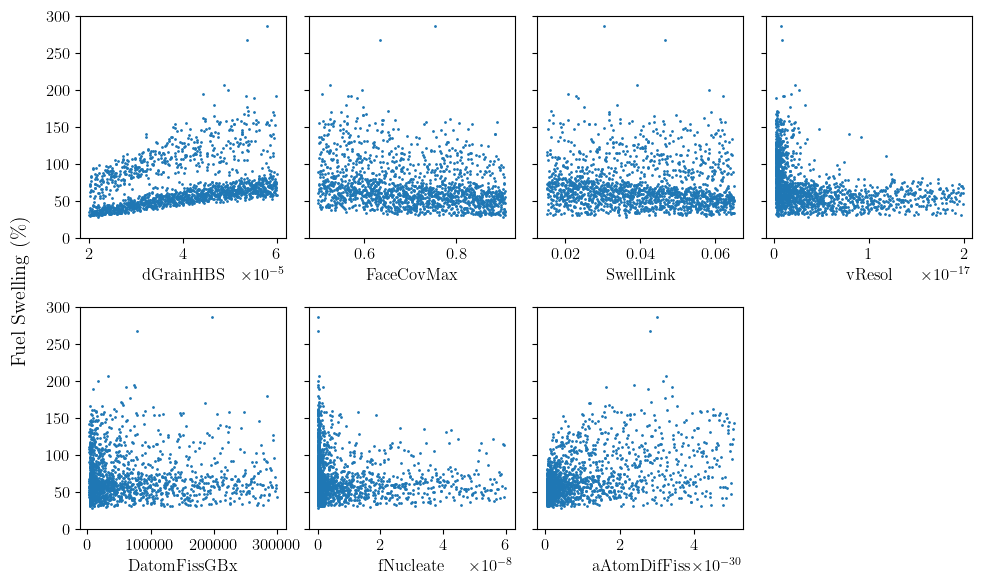

X:  <class 'numpy.ndarray'> (1600, 7)
y:  <class 'numpy.ndarray'> (1600, 1)


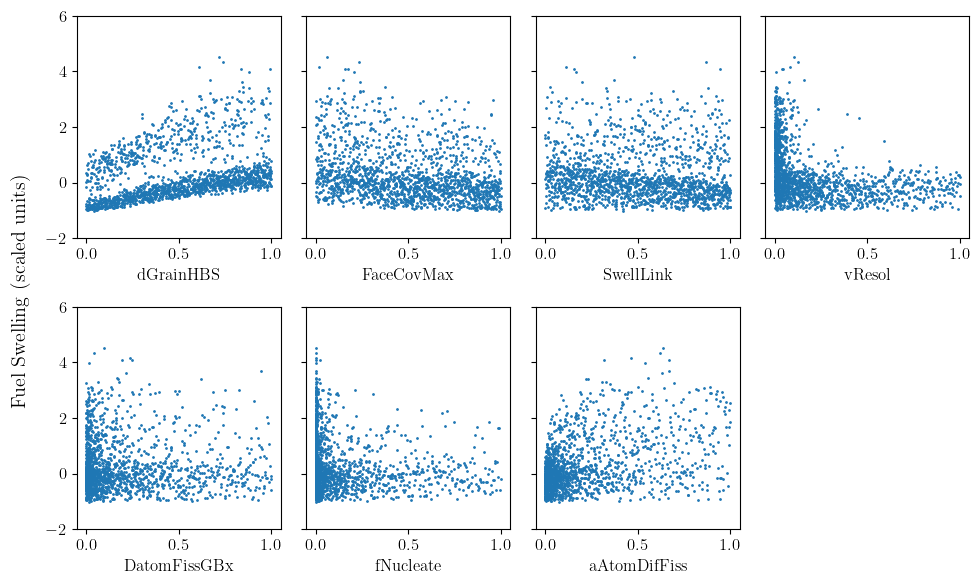

Nonextreme shapes:  (1595, 7) (1595, 1)
Extreme shapes:  (5, 7) (5, 1)
Cluster 0 shape:  (1108, 8)
Cluster 1 shape:  (487, 8)


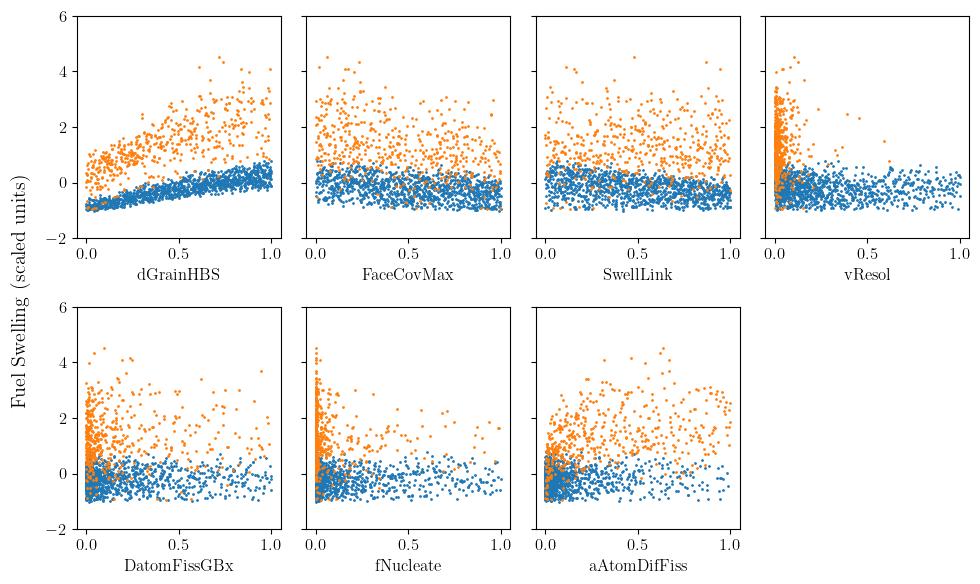

(1108, 7)
(1108, 1)
(487, 7)
(487, 1)


In [12]:
wrapper(
    'clean_hi_FR_hi_GS_160C.csv',
    'trial.csv',
    1,
    [0, 300],
    [-2, 6]
)

# Discarded code

In [13]:
#km = KMeans(n_clusters=2, random_state=40).fit(d2)
#
#plt.scatter(d2[:,0], d2[:,7], s=1, c=km.labels_)
#plt.show()

In [14]:
#db = DBSCAN(eps=0.6, min_samples=150).fit(d2)
#
#plt.scatter(d2[:,0], d2[:,7], s=1, c=db.labels_)
#plt.show()

In [15]:
#from matplotlib.patches import Ellipse
#
#def draw_ellipse(gmm, ax):
#    for pos, cov, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
#        if cov.shape == (2,2):
#            v, w_ = np.linalg.eigh(cov)
#            angle = np.degrees(np.arctan2(*w_[:,0][::-1]))
#            width, height = 2 * np.sqrt(v)
#            ellip = Ellipse(pos, width, height, angle=angle, alpha=0.3, edgecolor='black')
#            ax.add_patch(ellip)
#
#fig, ax = plt.subplots(figsize=(5, 4))
#scatter = ax.scatter(d1[:,0], d1[:,1], s=1, c=gmm.fit_predict(d1))
#draw_ellipse(gmm, ax)
#plt.ylim([-3, 3])
#plt.show()